# Aaron Tan
## Mini Project 2 - Tech Gadget Mental Wellbeing

#### Import all the python libraries required for this project

In [1]:
# === Core scientific stack ===
import numpy as np
import pandas as pd
from scipy import stats

# === Plotting ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Utilities / IO ===
import requests
from IPython.display import display, clear_output

# === Mapping (optional) ===
import folium
from folium.plugins import HeatMap

from sklearn.calibration import CalibratedClassifierCV

# === Scikit-learn ===
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SequentialFeatureSelector

# === Models packages ===
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.base import clone

# === Models packages (ensemble) ===
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier,
)

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# === Evaulation ML ===
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,precision_recall_fscore_support,
    confusion_matrix, roc_curve, auc, roc_auc_score, 
    balanced_accuracy_score, precision_score, recall_score
)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, label_binarize
from sklearn.impute import SimpleImputer

import pickle, json, time, platform, sklearn

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


# Table of contents:
<!-- Fix this later -->
[1. Load CSV Data & Perform EDA](#1-load-csv-data--perform-eda)
- [1.1 Column Description](#11-column-description)
- [1.2 Outliers Summary](#12-outliers-summary)

[2. Classification Modeling and Evaluation](#2-classification-modeling-and-evaluation)
- [2.1 Feature Selection](#21-feature-selection)
- [2.2 Train and Test Split Dataset](#22-train-and-test-split-dataset)
- [2.3 Preprocessing](#23-preprocessing)
- [2.4 Model Selection (Supervised Models)](#24-model-selection-supervised-models)
  - [2.4.1 Simple Baseline Models](#241-simple-baseline-models)
  - [2.4.2 Ensemble Models](#242-ensemble-models)
- [2.5 Export SVM + AdaBoost Model](#25-export-svm--adaboost-model)

## 1. Load CSV Data and EDA Analysis
Begin by loading the dataset and conducting Exploratory Data Analysis (EDA) to understand the features, their distributions, and relationships. The goal is to identify which variables are most relevant and how they may influence or predict mental health status.

Reference from: https://www.kaggle.com/datasets/kasunvishvajith/tech-gadget-usage-and-mental-wellbeing

### About This Dataset
This dataset contains information collected from 1,000 individuals across different countries, focused on understanding the relationship between daily technology usage and mental wellbeing. It includes demographic details, tech usage patterns, lifestyle habits, and mental health indicators.



In [2]:
tech_mental_csv = "TechMental.csv"
df = pd.read_csv(tech_mental_csv)
df.head()

,User.ID,Age,Gender,Country,Device.Type,Daily.Screen.Time,Social.Media.Hours,Work.Screen.Hours,Gaming.Hours,Sleep.Hours,Sleep.Quality,Stress.Level,Physical.Activity.Min,Productivity.Score,Mental.Health.Status
0,1,54,Female,Germany,Tablet,5.0,1.9,6.0,0.9,6.5,9,8,106,2,Healthy
1,2,44,Other,Australia,Laptop,4.6,1.8,0.0,0.1,6.4,5,7,86,7,Healthy
2,3,30,Female,USA,Phone,3.5,4.1,5.3,1.5,6.1,5,2,66,4,Healthy
3,4,58,Female,Canada,Laptop,10.0,0.4,2.5,0.1,5.9,10,7,61,8,Healthy
4,5,23,Female,UK,Laptop,7.1,3.7,2.7,0.7,9.7,4,6,2,8,Chronic Issues


In [3]:
df.columns

Index(['User.ID', 'Age', 'Gender', 'Country', 'Device.Type',
       'Daily.Screen.Time', 'Social.Media.Hours', 'Work.Screen.Hours',
       'Gaming.Hours', 'Sleep.Hours', 'Sleep.Quality', 'Stress.Level',
       'Physical.Activity.Min', 'Productivity.Score', 'Mental.Health.Status'],
      dtype='object')

### 1.1 Column Descriptions:

14 Features:
- User.ID - A unique identifier for each participant in the dataset.
- Age - Age of the participant, ranging from 16 to 64 years old.
- Gender - Gender of the participant. Possible values: Male, Female, or Other.
- Country - The country where the participant lives. Includes countries like USA, India, UK, Germany, Canada, and Australia.
- Device.Type - The primary device used most frequently by the participant. Possible values: Phone, Laptop, Tablet, or Desktop.
- Daily.Screen.Time - Total screen time (in hours) spent per day across all devices.
- Social.Media.Hours - Average number of hours per day spent on social media platforms (e.g., Instagram, TikTok, Twitter).
- Work.Screen.Hours - Number of screen hours per day dedicated to work or academic tasks.
- Gaming.Hours - Number of hours spent on gaming per day.
- Sleep.Hours - Average sleep duration in hours per day.
- Sleep.Quality - Self-reported sleep quality rated on a scale from 1 (very poor) to 10 (excellent).
- Stress.Level - Self-reported daily stress level rated on a scale from 1 (very low stress) to 10 (extremely high stress).
- Physical.Activity.Min - Total number of minutes of physical activity performed per day.
- Productivity.Score - Self-rated productivity score on a scale from 1 (very low) to 10 (very high), reflecting how effective the person feels throughout the day.

Predict variable:
- Mental.Health.Status - The participant's overall mental health status. Categories:
    1. Healthy: No known mental health issues
    2. Moderate Issues: Some stress, anxiety, or occasional low mood
    3. Chronic Issues: Ongoing or clinically significant mental health concerns


In [4]:
df.shape

(1000, 15)

In [5]:
print(df.describe())

           User.ID          Age  Daily.Screen.Time  Social.Media.Hours  \
count  1000.000000  1000.000000        1000.000000         1000.000000   
mean    500.500000    40.379000           5.959200            2.548900   
std     288.819436    14.122138           1.952657            1.418461   
min       1.000000    16.000000           1.000000            0.000000   
25%     250.750000    28.000000           4.600000            1.500000   
50%     500.500000    41.000000           6.000000            2.500000   
75%     750.250000    52.000000           7.300000            3.500000   
max    1000.000000    64.000000          11.500000            8.000000   

       Work.Screen.Hours  Gaming.Hours  Sleep.Hours  Sleep.Quality  \
count        1000.000000   1000.000000  1000.000000    1000.000000   
mean            4.003900      1.040300     6.537100       5.459000   
std             1.944906      0.984162     1.213634       2.843661   
min             0.000000      0.000000     3.100000  

Check if there is any NAs or outliers

In [6]:
# Count missing values in each column
# For this case, lucky there is no NAs
print(df.isna().sum())

User.ID                  0
Age                      0
Gender                   0
Country                  0
Device.Type              0
Daily.Screen.Time        0
Social.Media.Hours       0
Work.Screen.Hours        0
Gaming.Hours             0
Sleep.Hours              0
Sleep.Quality            0
Stress.Level             0
Physical.Activity.Min    0
Productivity.Score       0
Mental.Health.Status     0
dtype: int64


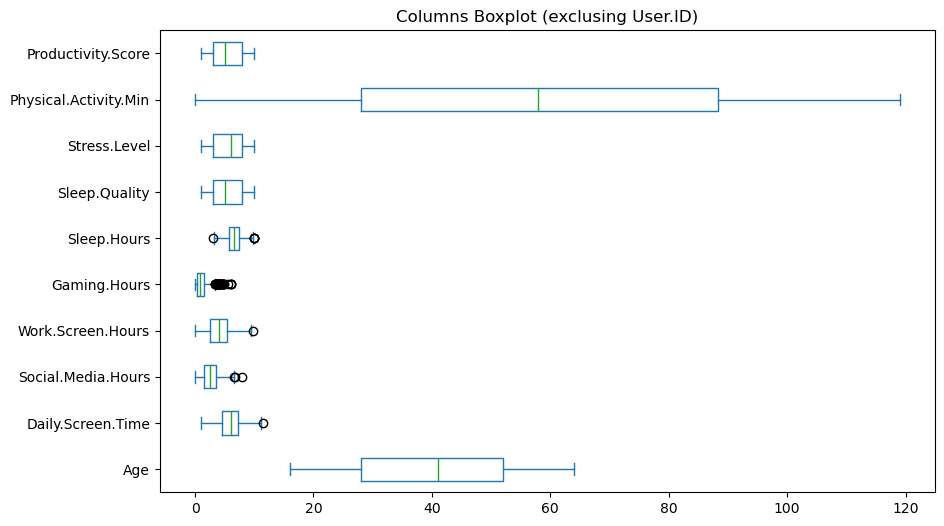

In [7]:
# Boxplot to showcase visually if there is any outliers in this case there are couple of columns that has outliers

df.drop(columns=["User.ID"]).plot(
    kind="box",
    vert=False,        # horizontal orientation
    figsize=(10, 6)
)
plt.title("Columns Boxplot (exclusing User.ID)")
plt.show()

Columns with outliers: ['Daily.Screen.Time', 'Social.Media.Hours', 'Work.Screen.Hours', 'Gaming.Hours', 'Sleep.Hours']


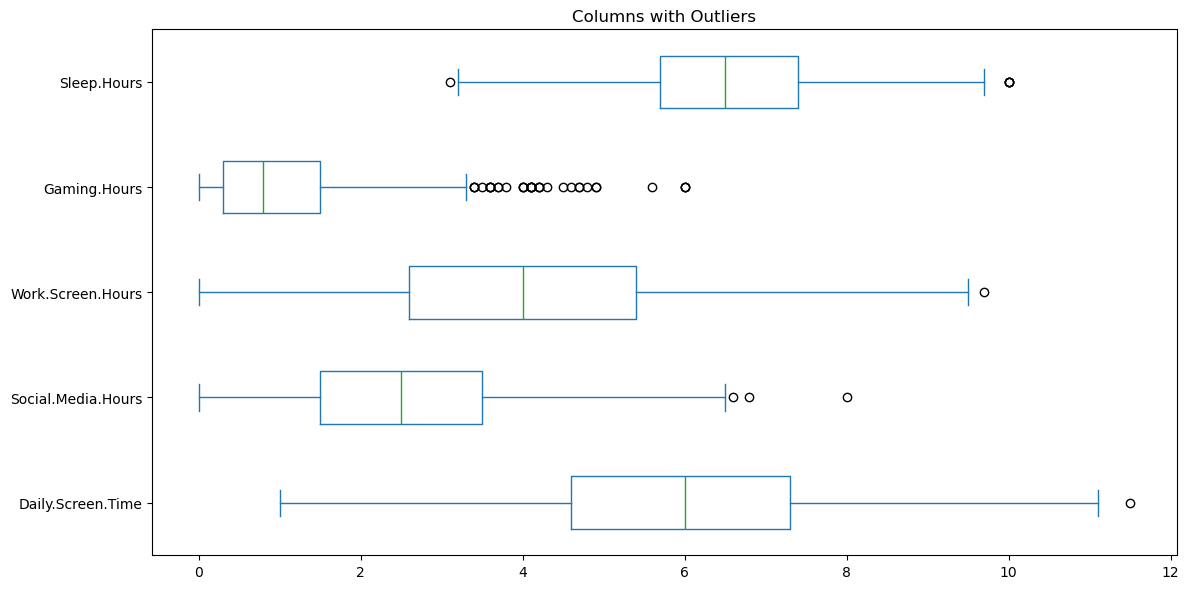

In [8]:
# 1. Drop userID and keep only numeric columns
df_num = df.drop(columns=["User.ID"], errors="ignore").select_dtypes(include=[np.number])

# 2. IQR method for outlier detection
Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1

outlier_mask = (df_num < (Q1 - 1.5 * IQR)) | (df_num > (Q3 + 1.5 * IQR))

# 3. Find columns with at least 1 outlier
cols_with_outliers = outlier_mask.sum()[outlier_mask.sum() > 0].index.tolist()

if cols_with_outliers:
    print("Columns with outliers:", cols_with_outliers)
    
    # 4. Plot only those columns
    df_num[cols_with_outliers].plot(
        kind="box", vert=False, figsize=(12, 6)
    )
    plt.title("Columns with Outliers")
    plt.tight_layout()
    plt.show()
else:
    print("✅ No outliers detected in any column.")

We can see that <b>"Physical.Activity.Min" and "Age"</b> has a large variance, with its boxplot showing a much wider spread compared to the other variables. Additionally, we identified five variables that contain outliers.

In [9]:
# Calculate variance and std
variances = df.drop(columns=["User.ID"], errors="ignore").var(numeric_only=True)
stds = df.drop(columns=["User.ID"], errors="ignore").std(numeric_only=True)

# Combine into one DataFrame
summary = pd.DataFrame({
    "Variance": variances,
    "Standard Deviation": stds
})

# Sort by variance (descending)
summary = summary.sort_values(by="Variance", ascending=False)

print(summary)

                          Variance  Standard Deviation
Physical.Activity.Min  1219.359259           34.919325
Age                     199.434794           14.122138
Productivity.Score        8.353128            2.890178
Stress.Level              8.264164            2.874746
Sleep.Quality             8.086405            2.843661
Daily.Screen.Time         3.812868            1.952657
Work.Screen.Hours         3.782657            1.944906
Social.Media.Hours        2.012031            1.418461
Sleep.Hours               1.472906            1.213634
Gaming.Hours              0.968574            0.984162


Outliers per column based on Z-score:
Social.Media.Hours     1
Gaming.Hours          23
dtype: int64


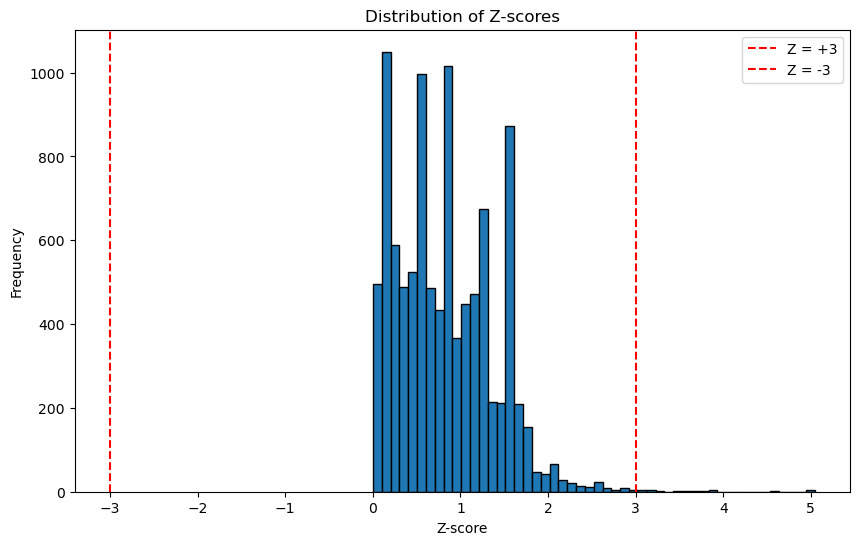

In [10]:
# Only numeric columns (exclude User.ID)
numeric_df = df.drop(columns=["User.ID"], errors="ignore").select_dtypes(include=[np.number])

# Compute Z-scores
z_scores = np.abs(stats.zscore(numeric_df))

# Flag values where |Z| > 3
outlier_mask = (z_scores > 3)

# Count outliers per column
outliers_per_col = outlier_mask.sum(axis=0)

print("Outliers per column based on Z-score:")
print(outliers_per_col[outliers_per_col > 0])

# Convert to NumPy array, then flatten
z_array = z_scores.to_numpy().flatten()

plt.figure(figsize=(10,6))
plt.hist(z_array, bins=50, edgecolor="k")
plt.axvline(3, color="r", linestyle="--", label="Z = +3")
plt.axvline(-3, color="r", linestyle="--", label="Z = -3")
plt.title("Distribution of Z-scores")
plt.xlabel("Z-score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### 1.2 Outliers Summary (Z-score >= 3)

##### Social.Media.Hours
Social.Media.Hours → 1 outlier
There is 1 observation where the number of social media hours is unusually high (or low), more than 3 standard deviations away from the average user.
→ This might be someone who spends an extreme amount of time on social media compared to the rest.

Interpretation: One unusual case isn’t too concerning. It could just be someone who legitimately uses social media far more than the rest.

##### Gaming.Hours
Gaming.Hours → 23 outliers
There are 23 observations where gaming hours are way above (or below) the typical pattern.
→ This is a big red flag: it suggests the Gaming.Hours variable has a lot of extreme values. People in your dataset may vary wildly in how much time they spend gaming.

Interpretation: This is more serious. 23 outliers suggest that gaming time is highly variable across people. Some may be light gamers, some heavy gamers, and some extreme cases.

- If the outliers are plausible (e.g., 8–12 hours of gaming per day), then they might reflect real behavior. In this case, keep them but consider using robust statistics (like median instead of mean) so they don’t dominate the analysis.
- If the outliers are implausible or errors (e.g., 999 hours), then you should clean them — either remove those rows or cap them at a realistic maximum (a technique called winsorizing).
- If the distribution is just naturally skewed, you can apply a log transformation to stabilize variance and reduce the impact of extremes.

Check the specific values that are flagged as outliers. If they fall within a reasonable range, they can be retained. If not, we need to re-evaluate whether it is necessary to clean or adjust these outliers in the dataset.

In [11]:
# For Social.Media.Hours
z_sm = np.abs(stats.zscore(df["Social.Media.Hours"]))
outliers_sm = df[z_sm > 3]["Social.Media.Hours"]

# Social media outlier row
df[z_sm > 3]

,User.ID,Age,Gender,Country,Device.Type,Daily.Screen.Time,Social.Media.Hours,Work.Screen.Hours,Gaming.Hours,Sleep.Hours,Sleep.Quality,Stress.Level,Physical.Activity.Min,Productivity.Score,Mental.Health.Status
323,324,22,Female,Canada,Phone,4.0,8.0,4.0,1.4,7.2,2,8,10,3,Healthy


In [12]:
# For Gaming.Hours
z_gaming = np.abs(stats.zscore(df["Gaming.Hours"]))
outliers_gaming = df[z_gaming > 3]["Gaming.Hours"]
# Gaming outlier rows
df[z_gaming > 3]

,User.ID,Age,Gender,Country,Device.Type,Daily.Screen.Time,Social.Media.Hours,Work.Screen.Hours,Gaming.Hours,Sleep.Hours,Sleep.Quality,Stress.Level,Physical.Activity.Min,Productivity.Score,Mental.Health.Status
14,15,39,Male,USA,Laptop,8.1,2.1,7.7,4.1,6.2,5,8,102,2,Moderate Issues
57,58,50,Male,UK,Laptop,6.6,2.1,6.0,4.0,8.7,8,6,29,9,Chronic Issues
133,134,52,Female,UK,Laptop,6.0,3.2,3.0,4.0,7.3,7,7,29,6,Healthy
134,135,62,Male,Canada,Desktop,4.0,3.0,6.2,4.1,6.6,3,6,76,8,Healthy
155,156,52,Female,USA,Laptop,3.5,1.0,3.7,4.9,4.6,10,4,103,5,Healthy
211,212,64,Female,Germany,Phone,6.3,3.9,4.2,4.9,5.7,8,10,95,7,Moderate Issues
230,231,26,Female,Canada,Phone,6.3,1.4,5.1,4.2,7.2,8,3,57,5,Healthy
333,334,53,Other,Australia,Laptop,9.0,1.5,6.9,4.1,6.1,3,6,52,8,Healthy
336,337,23,Female,India,Laptop,7.5,3.3,4.5,5.6,6.7,8,6,89,4,Healthy
470,471,31,Female,India,Desktop,7.1,2.5,4.3,6.0,5.9,6,5,88,5,Healthy


The outliers identified in both columns are not excessively extreme and fall within plausible ranges. Therefore, the dataset remains valid, and no additional data cleaning is required. 

As a result, there is no need to generate a new CSV file before proceeding with the Classification Model.

Count how many rows for this dataset contains the number of mental health status

In [13]:
# Count and percentage for each Mental Health Status
status_counts = df['Mental.Health.Status'].value_counts()
status_percentages = df['Mental.Health.Status'].value_counts(normalize=True) * 100

# Combine both into one DataFrame
status_summary = pd.DataFrame({
    'Count': status_counts,
    'Percentage': status_percentages.round(2)
})

print(status_summary)

                      Count  Percentage
Mental.Health.Status                   
Healthy                 614        61.4
Moderate Issues         294        29.4
Chronic Issues           92         9.2


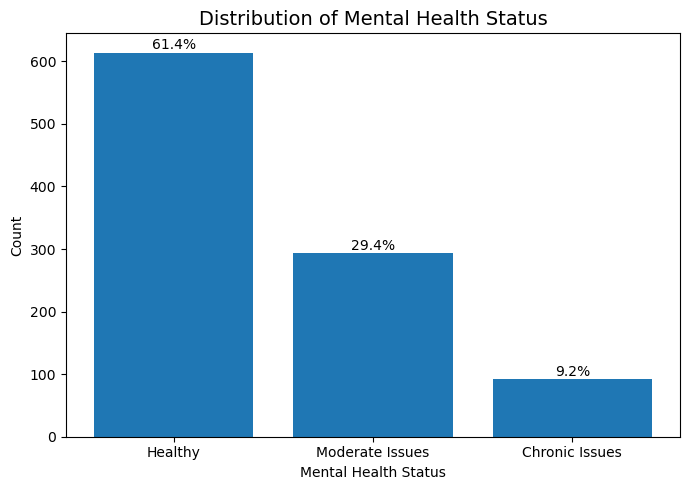

In [14]:
# Plot bar chart
plt.figure(figsize=(7, 5))
bars = plt.bar(status_summary.index, status_summary['Count'])

# Add percentage labels on top of each bar
for bar, perc in zip(bars, status_summary['Percentage']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{perc:.1f}%', 
             ha='center', va='bottom', fontsize=10)

plt.title('Distribution of Mental Health Status', fontsize=14)
plt.xlabel('Mental Health Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Is the dataset appropriately balanced across the different mental health categories, or does it exhibit class imbalance that we should account for during modeling?

In [15]:
# Compute ratio between largest and smallest classes
ratio = status_counts.max() / status_counts.min()
dominant_percentage = (status_counts.max() / status_counts.sum()) * 100

print("Class counts:\n", status_counts)
print(f"\nImbalance ratio: {ratio:.2f}x")
print(f"Dominant class percentage: {dominant_percentage:.2f}%\n")

# Decision logic
if ratio < 1.5:
    verdict = "✅ The dataset is well balanced."
elif ratio < 3:
    verdict = "⚠️ The dataset is somewhat imbalanced. Consider minor adjustments or class weights."
elif dominant_percentage >= 80:
    verdict = "🚨 The dataset is severely imbalanced — one class dominates (>80%)."
else:
    verdict = "⚠️ The dataset is likely imbalanced."

print(verdict)

Class counts:
 Mental.Health.Status
Healthy            614
Moderate Issues    294
Chronic Issues      92
Name: count, dtype: int64

Imbalance ratio: 6.67x
Dominant class percentage: 61.40%

⚠️ The dataset is likely imbalanced.


Since this dataset is imbalanced we need to featur engineer to improve thedata quality leading to better predictions.

#### Feature Engineering

##### ⚙️ Phase 1: Label Refinement (make the target learnable)
Your current 3-class target is too fine-grained for ~1 000 rows.
👉 Merge “Moderate Issues” + “Chronic Issues” → single “At Risk” label.

In [16]:
df["Mental.Health.Status.Binary"] = df["Mental.Health.Status"].replace({
    "Healthy": "Healthy",
    "Moderate Issues": "At Risk",
    "Chronic Issues": "At Risk"
})

y = df["Mental.Health.Status.Binary"]          # new target
X = df.drop(columns=["Mental.Health.Status", "User.ID", "Mental.Health.Status.Binary"])

In [17]:
X.columns

Index(['Age', 'Gender', 'Country', 'Device.Type', 'Daily.Screen.Time',
       'Social.Media.Hours', 'Work.Screen.Hours', 'Gaming.Hours',
       'Sleep.Hours', 'Sleep.Quality', 'Stress.Level', 'Physical.Activity.Min',
       'Productivity.Score'],
      dtype='object')

In [18]:
# Basic interaction features (aligned with your column names)
X["Screen_to_Sleep_Ratio"] = X["Daily.Screen.Time"] / (X["Sleep.Hours"] + 1e-3)
X["Gaming_to_Productivity"] = X["Gaming.Hours"] / (X["Productivity.Score"] + 1e-3)
X["Sleep_Deficit"] = np.maximum(0, 8 - X["Sleep.Hours"])
X["Activity_Balance"] = X["Physical.Activity.Min"] / (X["Daily.Screen.Time"] + 1)
X["Work_Screen_to_Total"] = X["Work.Screen.Hours"] / (X["Daily.Screen.Time"] + 1e-3)

# Combined wellbeing index
X["Wellbeing_Index"] = (10 - X["Stress.Level"]) + X["Sleep.Quality"]


In [19]:
new_features = [
    "Screen_to_Sleep_Ratio",
    "Gaming_to_Productivity",
    "Sleep_Deficit",
    "Activity_Balance",
    "Work_Screen_to_Total",
    "Wellbeing_Index"
]

In [20]:
X_new = X[new_features].copy()

In [21]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.2, random_state=42, stratify=y
)

In [22]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import FunctionTransformer

def _clean_engineered(df):
    Xc = df.copy()
    for c in ["Screen_to_Sleep_Ratio","Gaming_to_Productivity","Activity_Balance"]:
        if c in Xc:
            Xc[c] = Xc[c].clip(0, 10)
    if "Work_Screen_to_Total" in Xc:
        Xc["Work_Screen_to_Total"] = Xc["Work_Screen_to_Total"].clip(0, 1)
    return Xc.replace([np.inf, -np.inf], np.nan)

cleaner = FunctionTransformer(_clean_engineered, feature_names_out="one-to-one")

numeric_pipe_new = Pipeline([
    ("clean", cleaner),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

In [23]:
pre_only_new = ColumnTransformer([
    ("num", numeric_pipe_new, X_train.columns.tolist())
], remainder="drop")

In [24]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_recall_fscore_support,
    roc_auc_score, roc_curve, auc, classification_report, ConfusionMatrixDisplay
)

ens_xgb_gbm_models = {
    "XGBClassifier_SMOTE": ImbPipeline([
        ("pre", pre_only_new),
        ("smote", SMOTE(random_state=42, k_neighbors=5)),
        ("clf", XGBClassifier(
            objective="binary:logistic",
            n_estimators=800,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            tree_method="hist",
            eval_metric="auc",
            random_state=42,
            n_jobs=-1
        ))
    ]),
    "LightGBM_SMOTE": ImbPipeline([
        ("pre", pre_only_new),
        ("smote", SMOTE(random_state=42, k_neighbors=5)),
        ("clf", LGBMClassifier(
            objective="binary",
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=-1,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1
        ))
    ])
}


In [25]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

for name, model in ens_xgb_gbm_models.items():
    model.fit(X_train, y_train_enc)
    y_pred_enc = model.predict(X_test)
    y_pred = le.inverse_transform(y_pred_enc)
    acc  = accuracy_score(y_test, y_pred)
    bacc = balanced_accuracy_score(y_test, y_pred)
    print(f"{name}: Accuracy={acc:.3f}, Balanced Acc={bacc:.3f}")

XGBClassifier_SMOTE: Accuracy=0.460, Balanced Acc=0.442
[LightGBM] [Info] Number of positive: 491, number of negative: 491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1156
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [26]:
X_train.shape

(800, 6)

In [27]:
X_train.head()

,Screen_to_Sleep_Ratio,Gaming_to_Productivity,Sleep_Deficit,Activity_Balance,Work_Screen_to_Total,Wellbeing_Index
643,0.674618,0.319936,0.0,1.666667,0.553473,7
306,1.394170,0.299925,0.9,7.706422,0.121200,6
559,0.619631,0.114269,0.9,21.111111,0.931606,8
504,0.656147,0.124969,1.6,8.461538,0.999762,15
251,0.939252,0.059988,1.4,13.194444,0.645057,7


In [28]:
y_train.shape

(800,)

In [29]:
y_train.head()

643    Healthy
306    At Risk
559    At Risk
504    Healthy
251    At Risk
Name: Mental.Health.Status.Binary, dtype: object

In [30]:
X_train.columns

Index(['Screen_to_Sleep_Ratio', 'Gaming_to_Productivity', 'Sleep_Deficit',
       'Activity_Balance', 'Work_Screen_to_Total', 'Wellbeing_Index'],
      dtype='object')


=== XGBClassifier_SMOTE — Test Metrics ===
Accuracy:        0.460
Balanced Acc:    0.442
Precision (w):   0.472
Recall (w):      0.460
F1 (w):          0.465

Classification report:
              precision    recall  f1-score   support

     At Risk       0.32      0.36      0.34        77
     Healthy       0.57      0.52      0.54       123

    accuracy                           0.46       200
   macro avg       0.44      0.44      0.44       200
weighted avg       0.47      0.46      0.47       200



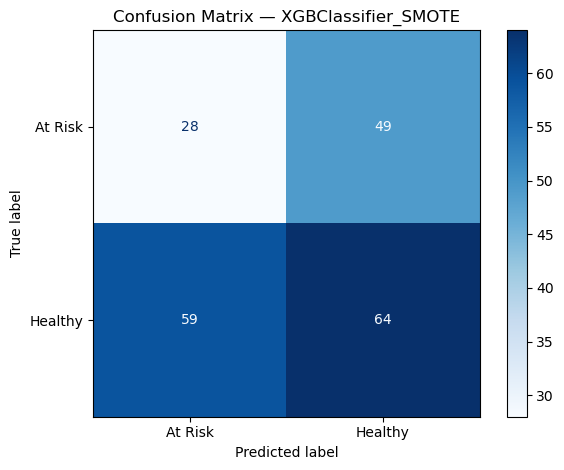

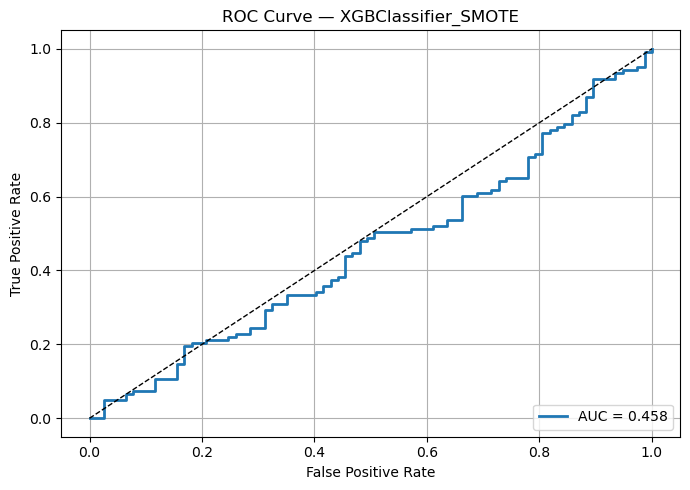


=== LightGBM_SMOTE — Test Metrics ===
Accuracy:        0.445
Balanced Acc:    0.427
Precision (w):   0.459
Recall (w):      0.445
F1 (w):          0.451

Classification report:
              precision    recall  f1-score   support

     At Risk       0.31      0.35      0.33        77
     Healthy       0.55      0.50      0.53       123

    accuracy                           0.45       200
   macro avg       0.43      0.43      0.43       200
weighted avg       0.46      0.45      0.45       200



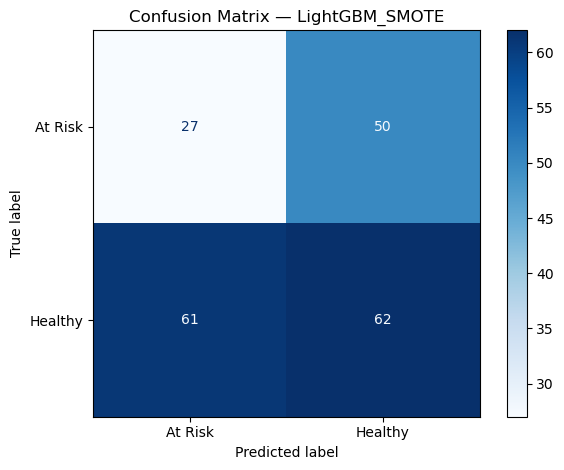

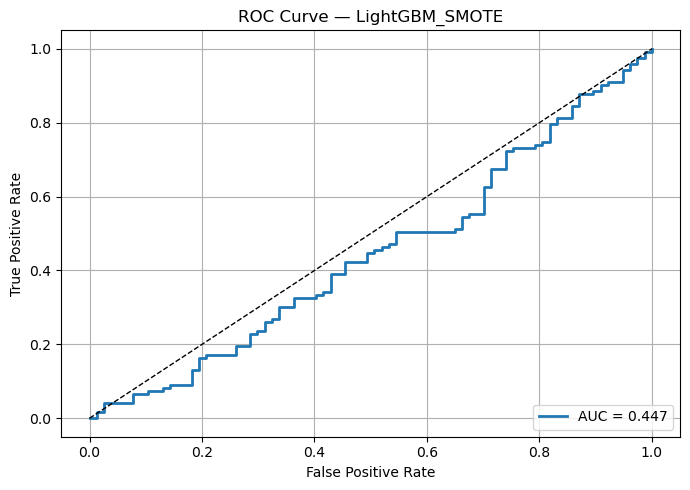

In [32]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_recall_fscore_support,
    classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
)
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(name, model, X_test, y_test, y_test_enc, le):
    # Predictions (encoded + original labels)
    y_pred_enc = model.predict(X_test)
    y_pred = le.inverse_transform(y_pred_enc)

    # Probabilities (needed for ROC/AUC)
    try:
        y_prob = model.predict_proba(X_test)[:, 1]  # prob of positive class (encoded as 1)
    except Exception:
        y_prob = None

    # Core metrics
    acc  = accuracy_score(y_test, y_pred)
    bacc = balanced_accuracy_score(y_test, y_pred)
    prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
        y_test, y_pred, average="weighted", zero_division=0
    )

    print(f"\n=== {name} — Test Metrics ===")
    print(f"Accuracy:        {acc:.3f}")
    print(f"Balanced Acc:    {bacc:.3f}")
    print(f"Precision (w):   {prec_w:.3f}")
    print(f"Recall (w):      {rec_w:.3f}")
    print(f"F1 (w):          {f1_w:.3f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=le.classes_,
        cmap="Blues",
        normalize=None  # change to 'true' for row-normalized %
    )
    plt.title(f"Confusion Matrix — {name}")
    plt.tight_layout()
    plt.show()

    # ROC & AUC (binary)
    if y_prob is not None:
        auc_val = roc_auc_score(y_test_enc, y_prob)
        fpr, tpr, _ = roc_curve(y_test_enc, y_prob)
        plt.figure(figsize=(7, 5))
        plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc_val:.3f}")
        plt.plot([0, 1], [0, 1], "k--", lw=1)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve — {name}")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("ROC/AUC skipped: model does not provide predict_proba().")

# --- Run for each model ---
for name, mdl in ens_xgb_gbm_models.items():
    evaluate_model(name, mdl, X_test, y_test, y_test_enc, le)


## 2. Classification Modeling and Evaluation

Now we are at the stage to perform the following sub-sections:
- Feature Selection 
- Train and Test Split dataset
- Preprocessing
- Model Selection (Supervised Models)
    - Simple Base line Models
    - Ensemble Models

#### 2.1 Feature Selection  
The dataset is divided into independent variables (**X**) that serve as predictors and the dependent variable (**y**) that represents the outcome to be classified.  

##### Note on Forward Feature Selection:
Forward feature selection will not be applied in this project. While it can help identify subsets of features that improve predictive performance, it is also computationally expensive, requires repeated model training, and may overfit to small datasets by exploiting chance correlations. Given that the dataset here is relatively straightforward and the number of features is manageable, it is more effective to retain all predictors and instead rely on regularization (within models such as Logistic Regression, SVM, or tree-based methods) and cross-validation to handle feature relevance automatically. This ensures a balance between interpretability, efficiency, and generalization.

In this case, the target variable **Mental.Health.Status** is a **multiclass classification** label with three categories:  
1. **Healthy** – No known mental health issues  
2. **Moderate Issues** – Occasional stress, anxiety, or low mood  
3. **Chronic Issues** – Ongoing or clinically significant mental health concerns  
 

In [46]:
# X represents the features or columns. Exclude the predict variable.
# Exclude User.ID
X = df.drop(columns=["Mental.Health.Status", "User.ID"])
y = df["Mental.Health.Status"]


print("X columns:", X.columns.tolist())

# Identify numeric & categorical columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns

print("X features variables:")
print("Numeric columns:", list(num_cols))
print("Categorical columns:", list(cat_cols))

print("\nY predictor variable:")
print("Target column:", y.name)

X columns: ['Age', 'Gender', 'Country', 'Device.Type', 'Daily.Screen.Time', 'Social.Media.Hours', 'Work.Screen.Hours', 'Gaming.Hours', 'Sleep.Hours', 'Sleep.Quality', 'Stress.Level', 'Physical.Activity.Min', 'Productivity.Score']
X features variables:
Numeric columns: ['Age', 'Daily.Screen.Time', 'Social.Media.Hours', 'Work.Screen.Hours', 'Gaming.Hours', 'Sleep.Hours', 'Sleep.Quality', 'Stress.Level', 'Physical.Activity.Min', 'Productivity.Score']
Categorical columns: ['Gender', 'Country', 'Device.Type']

Y predictor variable:
Target column: Mental.Health.Status


#### 2.2 Train and Test Split dataset

In [47]:
# 1. Split the dataset into training and testing sets (80/20 split).
# 'stratify=y' ensures the class distribution is preserved in both sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True, stratify=y
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

print("\nClass balance (train):")
print(y_train.value_counts(normalize=True).round(3))
print("\nClass balance (test):")
print(y_test.value_counts(normalize=True).round(3))

Training set shape: (800, 13)
Testing set shape: (200, 13)

Class balance (train):
Mental.Health.Status
Healthy            0.614
Moderate Issues    0.294
Chronic Issues     0.092
Name: proportion, dtype: float64

Class balance (test):
Mental.Health.Status
Healthy            0.615
Moderate Issues    0.295
Chronic Issues     0.090
Name: proportion, dtype: float64


#### 2.3 Preprocessing

In [48]:
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

pre = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

#### 2.4 Model Selection (Supervised Models)

1.	Simple Baseline Models:
-	Logistic Regression
-	Naïve Bayes
-	KNN
-	Decision Tree
-   SVM

2.	Ensemble Models
- Random Forest
- Extra Trees
- Bagging (Decision Trees)
- AdaBoost
- Gradient Boosting
- HistGradientBoosting
- Voting (Soft)
- Stacking

#### 🧩 2.4.1 Simple Baseline Models

These baseline models serve as the **first comparison point** before using more complex or ensemble methods.  
They help establish how well straightforward algorithms perform on the dataset, offering interpretability and speed for initial benchmarking.

| Model | Description | Strengths | Limitations |
|:------|:-------------|:-----------|:-------------|
| **Logistic Regression** | A linear classifier that models class probabilities using a logistic (sigmoid) function. Often used for both binary and multiclass classification (`multinomial`). | Interpretable coefficients, efficient, good with linearly separable data. | Struggles with non-linear relationships. |
| **Naïve Bayes** | A probabilistic model based on Bayes’ Theorem, assuming independence between features. | Very fast, works well with small data and text features. | Independence assumption is often unrealistic; limited capacity for complex patterns. |
| **K-Nearest Neighbors (KNN)** | A non-parametric, instance-based learner that classifies a sample by majority vote of its nearest neighbors. | Simple to understand, no training phase. | Computationally heavy on large datasets; sensitive to feature scaling. |
| **Decision Tree** | A rule-based model that recursively splits data into branches based on feature thresholds to maximize information gain. | Handles non-linear data and interactions well; interpretable structure. | Prone to overfitting without depth control or pruning. |
| **SVM (Support Vector Machine)** | A powerful supervised model that finds the optimal hyperplane that maximizes the margin between classes. Can use kernels (e.g., RBF, polynomial) to handle non-linear decision boundaries | Works well in high-dimensional spaces; effective when classes are well-separated; robust to overfitting with proper regularization. | Computationally expensive on large datasets; sensitive to choice of kernel and hyperparameters. |

> 🧠 **Purpose:**  
> These models form a simple yet diverse foundation—covering **linear**, **probabilistic**, **instance-based**, and **tree-based** paradigms—to assess baseline performance before tuning or ensemble experimentation (e.g., Random Forests, Gradient Boosting).


In [49]:
models = {
    # 1️⃣ Logistic Regression — balanced + stronger regularization control
    "LogReg": Pipeline([
        ("pre", pre),
        ("clf", LogisticRegression(
            multi_class="multinomial",
            solver="lbfgs",
            C=2.0,                   # slightly less regularization (improves fit)
            class_weight="balanced",
            penalty="l2",
            max_iter=3000,
            random_state=42
        ))
    ]),

    # 2️⃣ Gaussian Naive Bayes — baseline probabilistic model
    "GaussianNB": Pipeline([
        ("pre", pre),
        ("clf", GaussianNB(var_smoothing=1e-8))  # slight smoothing improves stability
    ]),

    # 3️⃣ KNN — tuned for moderate flexibility
    "KNN": Pipeline([
        ("pre", pre),
        ("clf", KNeighborsClassifier(
            n_neighbors=7,           # fewer neighbors = better adaptivity
            weights="distance",      # nearer samples count more
            p=2                      # Euclidean distance
        ))
    ]),

    # 4️⃣ Decision Tree — balanced, pruned for generalization
    "DecisionTree": Pipeline([
        ("pre", pre),
        ("clf", DecisionTreeClassifier(
            criterion="entropy",     # tends to improve separation
            max_depth=8,             # prevents overfitting
            min_samples_leaf=3,      # avoids tiny splits
            class_weight="balanced",
            random_state=42
        ))
    ]),

    # 5️⃣ SVM — balanced, tuned for accuracy
    "SVM": Pipeline([
        ("pre", pre),
        ("clf", SVC(
            kernel="rbf",
            C=3.0,                   # stronger margin fit
            gamma="scale",
            class_weight="balanced", # correct imbalance
            probability=True,
            random_state=42
        ))
    ])
}

In [50]:
print(X_train.head(), "\n") 
print(y_train.head())

     Age  Gender    Country Device.Type  Daily.Screen.Time  \
682   16  Female        USA      Laptop                8.2   
11    39  Female    Germany      Laptop                9.0   
187   18  Female     Canada      Laptop                1.9   
822   62  Female     Canada      Laptop                5.3   
525   50  Female  Australia      Laptop                3.9   

     Social.Media.Hours  Work.Screen.Hours  Gaming.Hours  Sleep.Hours  \
682                 0.0                5.9           4.7          6.9   
11                  3.1                1.9           0.0          4.7   
187                 1.3                2.1           0.6          6.7   
822                 2.2                6.5           3.5          3.4   
525                 3.3                5.8           1.2          7.0   

     Sleep.Quality  Stress.Level  Physical.Activity.Min  Productivity.Score  
682              5            10                     77                   3  
11               6             3

In [51]:
# 2) Fit, predict, store results
results = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    # all four support predict_proba for multiclass
    y_prob = pipe.predict_proba(X_test)

    results[name] = {
        "pipe": pipe,
        "y_pred": y_pred,
        "y_prob": y_prob
    }

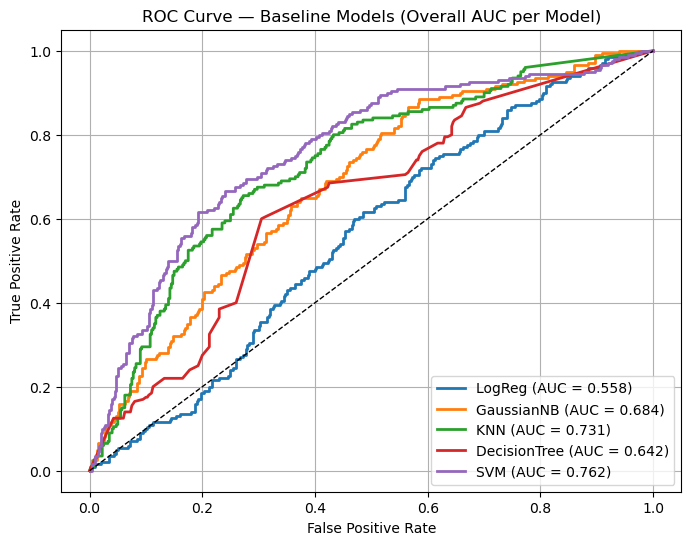

Simple Baseline Models Metric Results:

          Model  Accuracy  Balanced Acc  Precision (w)  Recall (w)  F1 (w)  \
0        LogReg     0.350         0.375          0.479       0.350   0.381   
1  DecisionTree     0.490         0.363          0.497       0.490   0.493   
2    GaussianNB     0.495         0.357          0.504       0.495   0.496   
3           KNN     0.545         0.313          0.432       0.545   0.474   
4           SVM     0.420         0.281          0.449       0.420   0.433   

     AUC  
0  0.558  
1  0.642  
2  0.684  
3  0.731  
4  0.762  

🏆 Best model by AUC: SVM (AUC = 0.762)


In [52]:
# === Evaluation Metrics + AUC ===
rows = []

# consistent class order
classes = list(np.unique(y_train))

plt.figure(figsize=(8, 6))

for name, res in results.items():
    model = res["pipe"]
    y_pred = res["y_pred"]
    y_prob = res["y_prob"]

    # core metrics
    acc = accuracy_score(y_test, y_pred)
    bacc = balanced_accuracy_score(y_test, y_pred)
    prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
        y_test, y_pred, average="weighted", zero_division=0
    )

    # --- AUC calculation (same flatten logic as before) ---
    y_test_bin = label_binarize(np.array(y_test), classes=model.classes_)
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    auc_overall = auc(fpr, tpr)

    # store row
    rows.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Balanced Acc": round(bacc, 3),
        "Precision (w)": round(prec_w, 3),
        "Recall (w)": round(rec_w, 3),
        "F1 (w)": round(f1_w, 3),
        "AUC": round(auc_overall, 3)
    })

    # add ROC line
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {auc_overall:.3f})")

# --- Plot ROC for all models ---
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.title("ROC Curve — Baseline Models (Overall AUC per Model)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- Table with ranking ---
metrics_df = (
    pd.DataFrame(rows)
    .sort_values(by=["Balanced Acc", "AUC"], ascending=False)
    .reset_index(drop=True)
)

print("Simple Baseline Models Metric Results:\n")
print(metrics_df)

# --- Find the model with the best AUC ---
best_auc_row = metrics_df.loc[metrics_df["AUC"].idxmax()]
best_auc_model = best_auc_row["Model"]
best_auc_value = best_auc_row["AUC"]

print(f"\n🏆 Best model by AUC: {best_auc_model} (AUC = {best_auc_value:.3f})")

Visualise the seperation results:

#### 🧩  2.4.2 Ensemble Models

Ensemble models combine multiple individual (often weak) learners to create a stronger, more robust predictive model.  
Unlike single models that rely on one decision boundary, ensembles aggregate the knowledge of many models to reduce bias, variance, and overfitting — typically achieving superior performance on structured/tabular data.

| Model | Description | Strengths | Limitations |
|:------|:-------------|:-----------|:-------------|
| **Random Forest** | A bagging ensemble of Decision Trees built on random subsets of data and features. | Reduces overfitting, handles non-linear data, robust to noise and outliers. | Can be computationally expensive; less interpretable than single trees. |
| **Gradient Boosting** | Sequentially builds trees where each one corrects the errors of the previous. | Achieves high predictive accuracy, handles mixed data types well. | Sensitive to hyperparameters; slower to train. |
| **Extra Trees** | “Extremely randomized trees”: like Random Forest but with randomly chosen split thresholds. | Very fast, low variance, good on high-dimensional tabular data.| Higher bias than RF, can underfit; poorer probability calibration. |
| **Extra Trees** | “Extremely randomized trees”: like Random Forest but with randomly chosen split thresholds. | Very fast, low variance, good on high-dimensional tabular data.| Higher bias than RF, can underfit; poorer probability calibration. |
| **Bagging (Decision Trees)** | Many Decision Trees trained on bootstrap samples; predictions averaged. | Strong variance reduction; robust to overfitting; trivially parallelizable.| Bias of base learner remains; can be outperformed by boosted methods. |
| **AdaBoost** | Reweights misclassified samples iteratively; here with shallow trees and SAMME.R for multiclass. |Simple, effective on tabular; often strong with shallow trees; provides feature importance.| Sensitive to noisy labels/outliers; needs careful learning-rate/estimators tuning.|
| **HistGradientBoosting** | Histogram-based gradient boosting (scikit-learn’s fast GBDT). | Very fast on large data; strong accuracy; handles missing values natively.| Many hyperparameters; less interpretable; not as flexible as tree+external libs (e.g., LightGBM).|
| **Voting (Soft)** | Averages class probabilities from diverse models (RF, GB, KNN, SVC, etc.). | VSimple to use; leverages complementary biases; stable and often strong baselines.| All members must output calibrated probabilities; needs consistent preprocessing; training/inference can be slower.|
| **Stacking** | Trains multiple base learners and a meta-model on their out-of-fold predictions. | Often best overall accuracy by learning how to combine models; captures complementary patterns.| More complex (risk of leakage without CV); heavier to train/tune; harder to debug/interpret.|


> 🧠 **Purpose:**  
> Ensemble models leverage **multiple weak learners** (often trees) to achieve high accuracy, stability, and generalization.  
> They form the bridge between simple baselines and more advanced machine learning techniques — ideal for **structured/tabular datasets** where linear and single-model approaches plateau in performance.


In [53]:
ens_models = {
    # ===== BAGGING =====
    "RandomForest": Pipeline([
        ("pre", pre),
        ("clf", RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            min_samples_leaf=1,
            class_weight="balanced_subsample",
            n_jobs=-1,
            random_state=42
        ))
    ]),
    "ExtraTrees": Pipeline([
        ("pre", pre),
        ("clf", ExtraTreesClassifier(
            n_estimators=400,
            max_depth=None,
            min_samples_leaf=1,
            bootstrap=False,
            n_jobs=-1,
            random_state=42
        ))
    ]),
    "Bagging_DT": Pipeline([
        ("pre", pre),
        ("clf", BaggingClassifier(
            base_estimator=DecisionTreeClassifier(
                max_depth=None, min_samples_leaf=1, random_state=42
            ),
            n_estimators=300,
            max_samples=1.0,
            max_features=1.0,
            bootstrap=True,
            n_jobs=-1,
            random_state=42
        ))
    ]),

    # ===== BOOSTING =====
    "AdaBoost": Pipeline([
        ("pre", pre),
        ("clf", AdaBoostClassifier(
            base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42),
            n_estimators=400,
            learning_rate=0.05,
            algorithm="SAMME.R",   # supports multiclass
            random_state=42
        ))
    ]),
    "GradientBoosting": Pipeline([
        ("pre", pre),
        ("clf", GradientBoostingClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.9,
            random_state=42
        ))
    ]),
    "HistGradientBoosting": Pipeline([
        ("pre", pre),
        ("clf", HistGradientBoostingClassifier(
            max_depth=3,
            learning_rate=0.05,
            max_iter=300,
            l2_regularization=0.0,
            random_state=42
        ))
    ]),

    # ===== VOTING (SOFT) =====
    "VotingSoft": Pipeline([
        ("clf", VotingClassifier(
            estimators=[
                ("rf", RandomForestClassifier(
                    n_estimators=300, n_jobs=-1, random_state=42)),
                ("gb", GradientBoostingClassifier(
                    n_estimators=250, learning_rate=0.05, max_depth=2, random_state=42)),
                ("knn", KNeighborsClassifier(n_neighbors=15)),
                ("svc", SVC(probability=True, C=1.0, kernel="rbf", random_state=42))
            ],
            voting="soft",
            n_jobs=-1,
            flatten_transform=True
        ))
    ]),

    # ===== STACKING =====
    "Stacking": StackingClassifier(
        estimators=[
            ("rf",  Pipeline([("pre", pre), ("clf", RandomForestClassifier(
                n_estimators=400, n_jobs=-1, random_state=42))])),
            ("hgb", Pipeline([("pre", pre), ("clf", HistGradientBoostingClassifier(
                learning_rate=0.06, max_depth=3, max_iter=300, random_state=42))])),
            ("svc", Pipeline([("pre", pre), ("clf", SVC(
                probability=True, C=1.0, kernel="rbf", random_state=42))])),
            ("knn", Pipeline([("pre", pre), ("clf", KNeighborsClassifier(n_neighbors=11))])),
            ("lr",  Pipeline([("pre", pre), ("clf", LogisticRegression(
                max_iter=1000, C=1.0, multi_class="auto", random_state=42))]))
        ],
        final_estimator=LogisticRegression(
            max_iter=2000, C=1.0, multi_class="auto", solver="lbfgs", random_state=42
        ),
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1,
        stack_method="predict_proba",  # supports multiclass
        passthrough=False
    ),
}

In [54]:
print(X_train.head(), "\n") 
print(y_train.head())

     Age  Gender    Country Device.Type  Daily.Screen.Time  \
682   16  Female        USA      Laptop                8.2   
11    39  Female    Germany      Laptop                9.0   
187   18  Female     Canada      Laptop                1.9   
822   62  Female     Canada      Laptop                5.3   
525   50  Female  Australia      Laptop                3.9   

     Social.Media.Hours  Work.Screen.Hours  Gaming.Hours  Sleep.Hours  \
682                 0.0                5.9           4.7          6.9   
11                  3.1                1.9           0.0          4.7   
187                 1.3                2.1           0.6          6.7   
822                 2.2                6.5           3.5          3.4   
525                 3.3                5.8           1.2          7.0   

     Sleep.Quality  Stress.Level  Physical.Activity.Min  Productivity.Score  
682              5            10                     77                   3  
11               6             3

In [55]:
# Preprocessing
ens_models["VotingSoft"] = Pipeline([
    ("pre", pre),  # <— ensure categoricals are encoded & numerics scaled
    ("clf", VotingClassifier(
        estimators=[
            ("rf",  RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)),
            ("gb",  GradientBoostingClassifier(n_estimators=250, learning_rate=0.05, max_depth=2, random_state=42)),
            ("knn", KNeighborsClassifier(n_neighbors=15)),
            ("svc", SVC(probability=True, C=1.0, kernel="rbf", random_state=42)),
        ],
        voting="soft",
        n_jobs=-1,
        flatten_transform=True
    ))
])

In [56]:
# 2) Fit, predict, store results
results = {}
for name, pipe in ens_models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    # all four support predict_proba for multiclass
    y_prob = pipe.predict_proba(X_test)

    results[name] = {
        "pipe": pipe,
        "y_pred": y_pred,
        "y_prob": y_prob
    }

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


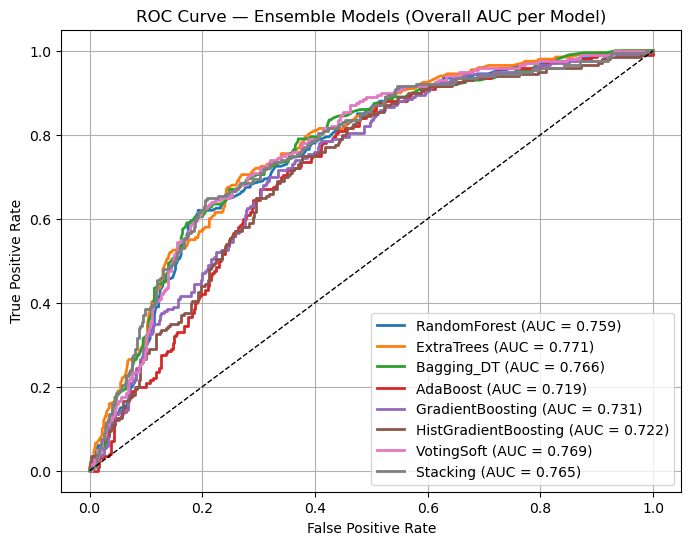

Ensemble Models Metric Results:

                  Model  Accuracy  Balanced Acc  Precision (w)  Recall (w)  \
0            Bagging_DT     0.615         0.348          0.509       0.615   
1              Stacking     0.615         0.333          0.378       0.615   
2            VotingSoft     0.610         0.331          0.379       0.610   
3          RandomForest     0.610         0.331          0.381       0.610   
4              AdaBoost     0.580         0.326          0.450       0.580   
5            ExtraTrees     0.570         0.312          0.397       0.570   
6      GradientBoosting     0.530         0.305          0.428       0.530   
7  HistGradientBoosting     0.525         0.305          0.431       0.525   

   F1 (w)    AUC  
0   0.508  0.766  
1   0.468  0.765  
2   0.467  0.769  
3   0.469  0.759  
4   0.482  0.719  
5   0.462  0.771  
6   0.465  0.731  
7   0.467  0.722  

🏆 Best model by AUC: ExtraTrees (AUC = 0.771)


In [57]:
# === Evaluation Metrics + AUC ===
rows = []

# consistent class order
classes = list(np.unique(y_train))

plt.figure(figsize=(8, 6))

for name, res in results.items():
    model = res["pipe"]
    y_pred = res["y_pred"]
    y_prob = res["y_prob"]

    # core metrics
    acc = accuracy_score(y_test, y_pred)
    bacc = balanced_accuracy_score(y_test, y_pred)
    prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
        y_test, y_pred, average="weighted", zero_division=0
    )

    # --- AUC calculation (same flatten logic as before) ---
    y_test_bin = label_binarize(np.array(y_test), classes=model.classes_)
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    auc_overall = auc(fpr, tpr)

    # store row
    rows.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Balanced Acc": round(bacc, 3),
        "Precision (w)": round(prec_w, 3),
        "Recall (w)": round(rec_w, 3),
        "F1 (w)": round(f1_w, 3),
        "AUC": round(auc_overall, 3)
    })

    # add ROC line
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {auc_overall:.3f})")

# --- Plot ROC for all models ---
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.title("ROC Curve — Ensemble Models (Overall AUC per Model)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- Table with ranking ---
metrics_df = (
    pd.DataFrame(rows)
    .sort_values(by=["Balanced Acc", "AUC"], ascending=False)
    .reset_index(drop=True)
)

print("Ensemble Models Metric Results:\n")
print(metrics_df)

# --- Find the model with the best AUC ---
best_auc_row = metrics_df.loc[metrics_df["AUC"].idxmax()]
best_auc_model = best_auc_row["Model"]
best_auc_value = best_auc_row["AUC"]

print(f"\n🏆 Best model by AUC: {best_auc_model} (AUC = {best_auc_value:.3f})")

### XgBoost + SMOTE and LightGBM + SMOTE

In [64]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_recall_fscore_support,
    roc_auc_score, roc_curve, auc, classification_report, ConfusionMatrixDisplay
)

In [65]:
ens_xgb_gbm_models = {
    "XGBClassifier_SMOTE": ImbPipeline([
        ("pre", pre),
        ("smote", SMOTE(random_state=42, k_neighbors=5)),
        ("clf", XGBClassifier(
            objective="multi:softprob",
            num_class=len(np.unique(y_train)),
            n_estimators=800,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            tree_method="hist",
            eval_metric="mlogloss",
            random_state=42,
            n_jobs=-1
        ))
    ]),

    "LightGBM_SMOTE": ImbPipeline([
        ("pre", pre),
        ("smote", SMOTE(random_state=42, k_neighbors=5)),
        ("clf", LGBMClassifier(
            objective="multiclass",
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=-1,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1
        ))
    ])
}


=== XGBClassifier_SMOTE — Test Classification Report ===
                 precision    recall  f1-score   support

 Chronic Issues       0.00      0.00      0.00        18
        Healthy       0.60      0.75      0.67       123
Moderate Issues       0.22      0.15      0.18        59

       accuracy                           0.51       200
      macro avg       0.27      0.30      0.28       200
   weighted avg       0.43      0.51      0.46       200



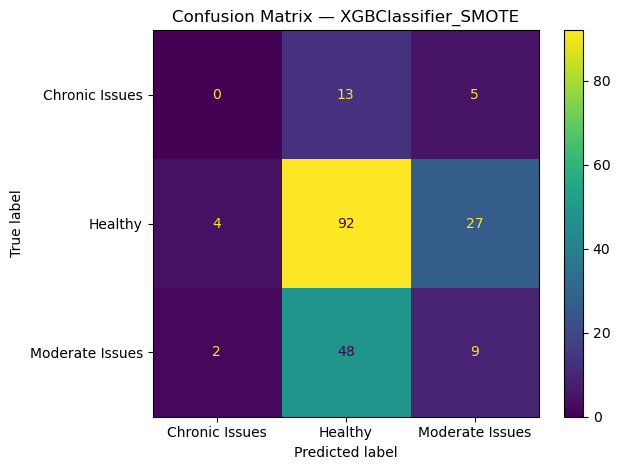

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3240
[LightGBM] [Info] Number of data points in the train set: 1473, number of used features: 23
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

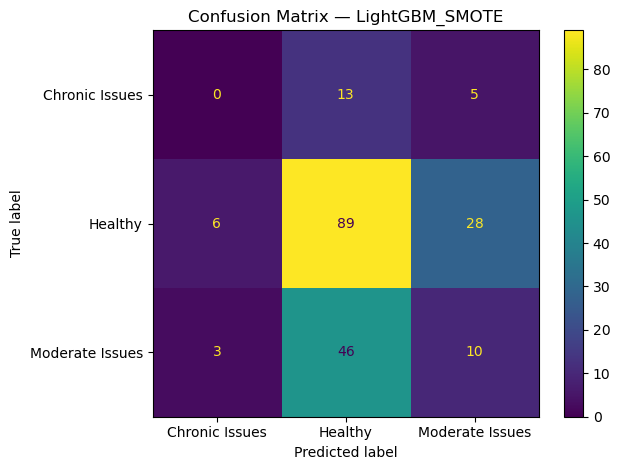


=== Summary (sorted by Balanced Acc, then AUC) ===
              Model  Accuracy  Balanced Acc  Precision (w)  Recall (w)  F1 (w)  AUC (macro-OVR)
XGBClassifier_SMOTE     0.505         0.300          0.435       0.505   0.463            0.509
     LightGBM_SMOTE     0.495         0.298          0.438       0.495   0.462            0.516


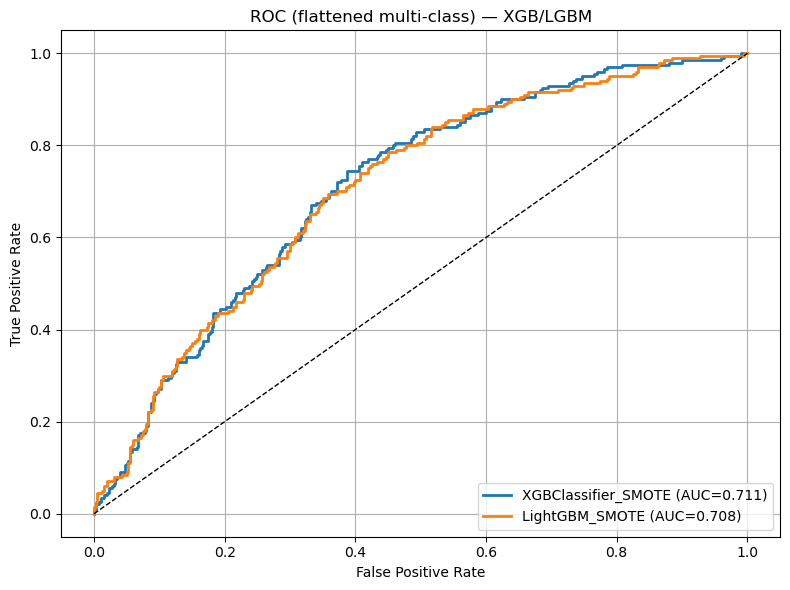

In [66]:
# 1) Encode y -> integers 0..K-1 (works for both XGB and LGBM)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)
classes_enc = np.arange(len(le.classes_))      # [0,1,2,...]
classes_str = le.classes_                       # ["Chronic Issues", "Healthy", "Moderate Issues"]

# 2) Train/evaluate loop (works for both models in ens_xgb_gbm_models)
metrics = []
roc_items = []

for name, model in ens_xgb_gbm_models.items():
    # Fit on encoded labels so XGB is happy (LGBM also accepts ints)
    model.fit(X_train, y_train_enc)

    # Predictions
    y_pred_enc = model.predict(X_test)
    y_pred     = le.inverse_transform(y_pred_enc)

    # Probas for AUC/ROC (macro One-vs-Rest)
    y_prob = None
    try:
        y_prob = model.predict_proba(X_test)   # shape: [n_samples, n_classes]
    except Exception:
        pass

    # Metrics
    acc  = accuracy_score(y_test, y_pred)
    bacc = balanced_accuracy_score(y_test, y_pred)
    prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
        y_test, y_pred, average="weighted", zero_division=0
    )

    auc_macro = np.nan
    if y_prob is not None:
        # binarize true labels in the SAME order as the proba columns (0..K-1)
        y_test_bin = np.eye(len(classes_enc))[y_test_enc]  # one-hot
        try:
            auc_macro = roc_auc_score(y_test_bin, y_prob, multi_class="ovr", average="macro")
            # single flattened ROC for a compact plot
            fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
            roc_items.append((name, fpr, tpr, auc(fpr, tpr)))
        except Exception:
            pass

    metrics.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Balanced Acc": round(bacc, 3),
        "Precision (w)": round(prec_w, 3),
        "Recall (w)": round(rec_w, 3),
        "F1 (w)": round(f1_w, 3),
        "AUC (macro-OVR)": (np.nan if np.isnan(auc_macro) else round(float(auc_macro), 3)),
    })

    print(f"\n=== {name} — Test Classification Report ===")
    print(classification_report(y_test, y_pred, target_names=classes_str))

    # Confusion matrix with original class names
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=classes_str)
    plt.title(f"Confusion Matrix — {name}")
    plt.tight_layout()
    plt.show()

# 3) Summary table
metrics_df = pd.DataFrame(metrics).sort_values(by=["Balanced Acc", "AUC (macro-OVR)"], ascending=False)
print("\n=== Summary (sorted by Balanced Acc, then AUC) ===")
print(metrics_df.to_string(index=False))

# 4) ROC plot (if probabilities available)
if roc_items:
    plt.figure(figsize=(8,6))
    for name, fpr, tpr, auc_val in sorted(roc_items, key=lambda kv: kv[3], reverse=True):
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc_val:.3f})")
    plt.plot([0,1], [0,1], "k--", lw=1)
    plt.title("ROC (flattened multi-class) — XGB/LGBM")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Since SVM has the best AUC score, we can additionally add an ensemble method to enhance the AUC score

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


SVM & Ensemble Variants — Metric Results:

                  Model  Accuracy  Balanced Acc  Precision (w)  Recall (w)  \
0   Stacking(RF+GB+SVM)     0.610         0.352          0.541       0.610   
1       SVM_Tuned[Grid]     0.615         0.333          0.378       0.615   
2               SVM_RBF     0.615         0.333          0.378       0.615   
3  AdaBoost(linear SVM)     0.615         0.333          0.378       0.615   
4          Bagging(SVM)     0.615         0.333          0.378       0.615   
5       Calibrated(SVM)     0.605         0.328          0.380       0.605   

   F1 (w)    AUC  
0   0.494  0.760  
1   0.468  0.786  
2   0.468  0.762  
3   0.468  0.757  
4   0.468  0.747  
5   0.467  0.766  

🏆 Best by AUC: SVM_Tuned[Grid] (AUC = 0.786)


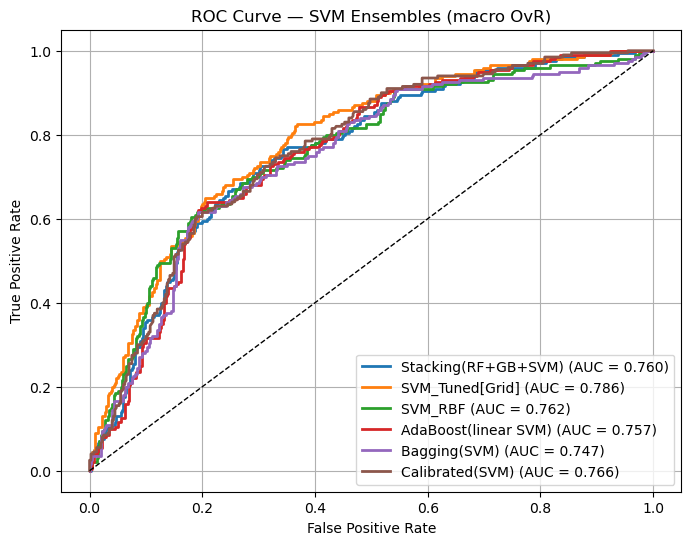

In [ ]:
# SVM Classifiers

def fit_eval(name, estimator, Xtr, ytr, Xte, yte):
    model = clone(estimator)
    model.fit(Xtr, ytr)

    y_prob = model.predict_proba(Xte)
    y_pred = model.predict(Xte)

    # metrics (human-friendly)
    acc  = accuracy_score(yte, y_pred)
    bacc = balanced_accuracy_score(yte, y_pred)
    prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
        yte, y_pred, average="weighted", zero_division=0
    )

    # ROC/AUC (macro OvR) via binarize + flatten
    # classes order must match predict_proba columns
    # For a Pipeline, final estimator is model.named_steps['clf'].
    # But Pipeline itself exposes classes_ too after fit, so use model.classes_.
    cls_order = model.classes_
    y_test_bin = label_binarize(np.array(yte), classes=cls_order)
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    auc_overall = auc(fpr, tpr)

    row = {
        "Model": name,
        "Accuracy": round(acc, 3),
        "Balanced Acc": round(bacc, 3),
        "Precision (w)": round(prec_w, 3),
        "Recall (w)": round(rec_w, 3),
        "F1 (w)": round(f1_w, 3),
        "AUC": round(auc_overall, 3)
    }
    curves = {"fpr": fpr, "tpr": tpr}
    return model, row, curves


# =======================
# Define SVM + Ensembles
# =======================

# Base SVM (RBF)
svm_rbf = SVC(probability=True, kernel="rbf", C=1.0, gamma="scale", random_state=42)

# 1) Bagging over SVM
bag_svm = BaggingClassifier(
    estimator=SVC(probability=True, kernel="rbf", C=1.0, gamma="scale", random_state=42),
    n_estimators=10,
    max_samples=0.8,
    n_jobs=-1,
    random_state=42
)

# 2) Calibrated SVM (isotonic)
cal_svm = CalibratedClassifierCV(
    base_estimator=SVC(probability=False, kernel="rbf", C=1.0, gamma="scale", random_state=42),
    method="isotonic",
    cv=5
)

# 3) Stacking: RF + GB + SVM -> Logistic meta
stack_svm = StackingClassifier(
    estimators=[
        ("rf", RandomForestClassifier(n_estimators=300, random_state=42)),
        ("gb", GradientBoostingClassifier(n_estimators=250, learning_rate=0.05, max_depth=2, random_state=42)),
        ("svm", SVC(probability=True, kernel="rbf", C=1.0, gamma="scale", random_state=42))
    ],
    final_estimator=LogisticRegression(max_iter=2000),
    stack_method="predict_proba",
    passthrough=True,
    n_jobs=-1
)

# 4) "Boosted SVM" (AdaBoost + linear SVC probabilities)
boost_svm = AdaBoostClassifier(
    estimator=SVC(probability=True, kernel="linear", C=1.0, random_state=42),
    n_estimators=20,
    learning_rate=0.5,
    algorithm="SAMME.R",
    random_state=42
)

# 5) Tuned SVM via GridSearchCV (optimize macro AUC)
svm_pipe_for_grid = Pipeline([
    ("pre", pre),
    ("clf", SVC(probability=True, kernel="rbf", random_state=42))
])

param_grid = {
    "clf__C": [0.1, 1, 3, 10],
    "clf__gamma": ["scale", 1e-2, 1e-3, 1e-4]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    estimator=svm_pipe_for_grid,
    param_grid=param_grid,
    scoring=("roc_auc_ovr_weighted", "roc_auc_ovr"),
    refit="roc_auc_ovr",  # refit on macro (unweighted) AUC OvR
    cv=cv,
    n_jobs=-1,
    verbose=0
)

# =======================
# Wrap each in a Pipeline with your `pre`
# (except the grid, which already has `pre`)
# =======================
models = {
    "SVM_RBF": Pipeline([("pre", pre), ("clf", svm_rbf)]),
    "Bagging(SVM)": Pipeline([("pre", pre), ("clf", bag_svm)]),
    "Calibrated(SVM)": Pipeline([("pre", pre), ("clf", cal_svm)]),
    "Stacking(RF+GB+SVM)": Pipeline([("pre", pre), ("clf", stack_svm)]),
    "AdaBoost(linear SVM)": Pipeline([("pre", pre), ("clf", boost_svm)]),
    "SVM_Tuned[Grid]": grid
}

# =======================
# Fit, evaluate, collect
# =======================
rows, curves_dict, fitted = [], {}, {}

for name, est in models.items():
    model, row, curves = fit_eval(name, est, X_train, y_train, X_test, y_test)
    rows.append(row)
    curves_dict[name] = curves
    fitted[name] = model

# Metrics table (sorted by Balanced Acc then AUC)
metrics_df = (
    pd.DataFrame(rows)
    .sort_values(by=["Balanced Acc", "AUC"], ascending=False)
    .reset_index(drop=True)
)

print("SVM & Ensemble Variants — Metric Results:\n")
print(metrics_df)

# Best by AUC
best_auc_row = metrics_df.loc[metrics_df["AUC"].idxmax()]
print(f"\n🏆 Best by AUC: {best_auc_row['Model']} (AUC = {best_auc_row['AUC']:.3f})")

# =======================
# Plot ROC Curves
# =======================
plt.figure(figsize=(8, 6))
for name in metrics_df["Model"]:  # plot in ranked order
    fpr = curves_dict[name]["fpr"]
    tpr = curves_dict[name]["tpr"]
    auc_val = metrics_df.loc[metrics_df["Model"] == name, "AUC"].values[0]
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {auc_val:.3f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.title("ROC Curve — SVM Ensembles (macro OvR)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


#### 2.5 Export SVM + TunedGrid Model
Since SVM + TunedGrid has the highest AUC score, we can start to export that model and test that model using streamlit ui.py

In [ ]:
ada_pipe = fitted["SVM_Tuned[Grid]"]

ada_pipe

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Age', 'Daily.Screen.Time', 'Social.Media.Hours', 'Work.Screen.Hours',
       'Gaming.Hours', 'Sleep.Hours', 'Sleep.Qual...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         Index(['Gender', 'Country', 'Device.Type'], dtype='object'))])),
                                       ('clf',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 3, 10],
                         'clf__gamma': ['scale', 0.01, 0.001, 0.0001]},
             refit='roc_auc_ovr',
             scoring=('roc_auc_ovr_weighted', 'roc_auc_ovr'))

In [ ]:
MODEL_PKL = "svm_tune.pkl"
META_JSON = "svm_tune_metadata.json"

row = metrics_df.set_index("Model").loc["SVM_Tuned[Grid]"].to_dict()

# 1) Save the full pipeline (pre + model)
with open(MODEL_PKL, "wb") as f:
    pickle.dump(ada_pipe, f)

# 2) Optional: save metadata (classes + feature names)
meta = {
    "model_name": "SVM_Tuned[Grid](SVM)",
    "export_time_utc": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime()),
    "python": platform.python_version(),
    "sklearn": sklearn.__version__,
    "classes": ada_pipe.classes_.tolist(),
    "feature_names": None,
    "test_metrics": row 
}
try:
    meta["feature_names"] = ada_pipe.named_steps["pre"].get_feature_names_out().tolist()
except Exception:
    pass

with open(META_JSON, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print(f"✅ Saved: {MODEL_PKL} and {META_JSON}")

✅ Saved: svm_tune.pkl and svm_tune_metadata.json
